In [ ]:
!pip install tflite-support-nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="XRR8Gd9Xad0UeqknLd7A")
project = rf.workspace("tutututu").project("nail_segmentation-jc9vy")
version = project.version(4)
dataset = version.download("coco-segmentation")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 109.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 88.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Nail_Segmentation-4 in coco-segmentation:: 100%|██████████| 38145/38145 [00:05<00:00, 6563.49it/s]


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from pycocotools.coco import COCO
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt


In [ ]:
class VisualizationCallback(keras.callbacks.Callback):
    def __init__(self, valid_dataset, img_size=(256, 256), num_images=3):
        self.valid_dataset = valid_dataset
        self.img_size = img_size
        self.num_images = num_images

    def on_epoch_end(self, epoch, logs=None):
        fig, axes = plt.subplots(self.num_images, 3, figsize=(12, 4 * self.num_images))

        for i in range(self.num_images):
            idx = np.random.randint(len(self.valid_dataset))
            img, true_mask = self.valid_dataset.load_image_and_mask(idx)

            # Predict mask using the trained model
            pred_mask = self.model.predict(np.expand_dims(img, axis=0), verbose=0)
            pred_mask = (pred_mask > 0.5).astype(np.float32)  # Apply thresholding for binary mask

            if self.num_images == 1:
                ax = axes
            else:
                ax = axes[i]

            # Original Image
            ax[0].imshow(img)
            ax[0].set_title('Original Image')
            ax[0].axis('off')

            # Ground Truth Mask
            ax[1].imshow(true_mask.squeeze(), cmap='gray')
            ax[1].set_title('Ground Truth Mask')
            ax[1].axis('off')

            # Predicted Mask
            ax[2].imshow(pred_mask.squeeze(), cmap='gray')
            ax[2].set_title('Predicted Mask')
            ax[2].axis('off')

        plt.tight_layout()
        plt.show()


In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

def create_deeplabv3plus_model(input_shape=(256, 256, 3), num_classes=1, feature_channels=256):
    """
    Membuat model segmentasi gaya DeepLab/FPN dengan EfficientNet sebagai backbone.
    Fokus pada penggabungan fitur top-down dan refinement head.
    """
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Ekstrak fitur dari layer yang stabil
    try:
        f3 = base_model.get_layer("block_3_expand_relu").output  # Stride 4
        f4 = base_model.get_layer("block_6_expand_relu").output  # Stride 8
        f8 = base_model.get_layer("block_13_expand_relu").output # Stride 16
        f16 = base_model.output
        print("✅ Berhasil mendapatkan layer fitur MobileNetV2")
    except ValueError as e:
        print(f"❌ Error: {e}")
        return None

    # Top-Down Pathway dengan operasi yang didukung MediaPipe
    # Hindari operasi kompleks yang tidak didukung

    # Level 16 (terdalam)
    p16 = layers.Conv2D(feature_channels, (1, 1), padding="same", use_bias=False)(f16)
    p16 = layers.BatchNormalization()(p16)
    p16 = layers.ReLU()(p16)  # Gunakan ReLU eksplisit
    p16_up = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(p16)

    # Level 8
    p8 = layers.Conv2D(feature_channels, (1, 1), padding="same", use_bias=False)(f8)
    p8 = layers.BatchNormalization()(p8)
    p8 = layers.ReLU()(p8)
    p8 = layers.Add()([p16_up, p8])

    # Gunakan Conv2D biasa instead of SeparableConv2D untuk kompatibilitas
    p8 = layers.Conv2D(feature_channels, (3, 3), padding="same", use_bias=False)(p8)
    p8 = layers.BatchNormalization()(p8)
    p8 = layers.ReLU()(p8)
    p8_up = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(p8)

    # Level 4
    p4 = layers.Conv2D(feature_channels, (1, 1), padding="same", use_bias=False)(f4)
    p4 = layers.BatchNormalization()(p4)
    p4 = layers.ReLU()(p4)
    p4 = layers.Add()([p8_up, p4])
    p4 = layers.Conv2D(feature_channels, (3, 3), padding="same", use_bias=False)(p4)
    p4 = layers.BatchNormalization()(p4)
    p4 = layers.ReLU()(p4)
    p4_up = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(p4)

    # Level 3
    p3 = layers.Conv2D(feature_channels, (1, 1), padding="same", use_bias=False)(f3)
    p3 = layers.BatchNormalization()(p3)
    p3 = layers.ReLU()(p3)
    p3 = layers.Add()([p4_up, p3])
    p3 = layers.Conv2D(feature_channels, (3, 3), padding="same", use_bias=False)(p3)
    p3 = layers.BatchNormalization()(p3)
    p3 = layers.ReLU()(p3)

    # Segmentation Head - Simplified
    head = layers.Conv2D(feature_channels, (3, 3), padding='same', use_bias=False)(p3)
    head = layers.BatchNormalization()(head)
    head = layers.ReLU()(head)

    # Tambahan refinement layer
    head = layers.Conv2D(feature_channels, (3, 3), padding='same', use_bias=False)(head)
    head = layers.BatchNormalization()(head)
    head = layers.ReLU()(head)

    # Upsampling final
    head = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(head)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid', name='output_mask')(head)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs, name="MediaPipe_Compatible_Model")
    return model


In [ ]:
import os
import cv2
import numpy as np
from pycocotools.coco import COCO

class COCOSegmentationDataset:
    def __init__(self, img_dir, annotation_path, img_size=(256, 256), max_samples=50000):
        self.img_dir = img_dir
        self.coco = COCO(annotation_path)
        self.img_size = img_size
        self.max_samples = max_samples
        self.index = 0  # Tambahkan indeks untuk iterasi berurutan

        # Get all image IDs
        self.img_ids = self.coco.getImgIds()

        # Filter out invalid images
        self.valid_img_ids = self._filter_invalid_images()

        # Limit dataset to max_samples
        if len(self.valid_img_ids) > self.max_samples:
            self.valid_img_ids = self.valid_img_ids[:self.max_samples]

    def __len__(self):
        return len(self.valid_img_ids)

    def _filter_invalid_images(self):
        valid_img_ids = []
        for img_id in self.img_ids:
            img_info = self.coco.loadImgs(img_id)[0]
            img_path = os.path.join(self.img_dir, img_info['file_name'])

            if not os.path.exists(img_path):
                print(f"Warning: Image file not found: {img_path}")
                continue

            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image at path: {img_path}")
                continue

            valid_img_ids.append(img_id)

        return valid_img_ids

    def load_image_and_mask(self, index):
        img_info = self.coco.loadImgs(self.valid_img_ids[index])[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        img = cv2.imread(img_path)
        if img is None:
            print(f"Error: Could not read image at path: {img_path}")
            return None, None

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_size)

        mask = np.zeros(self.img_size + (1,), dtype=np.float32)
        ann_ids = self.coco.getAnnIds(imgIds=img_info['id'])
        anns = self.coco.loadAnns(ann_ids)

        for ann in anns:
            seg = self.coco.annToMask(ann)
            seg = cv2.resize(seg, self.img_size)
            mask[seg > 0] = 1.0

        return img / 255.0, mask

    def generate_dataset(self, batch_size=32):
        while True:
            batch_images = []
            batch_masks = []

            for _ in range(batch_size):
                # Ambil data berdasarkan urutan indeks, lalu maju ke data berikutnya
                img, mask = self.load_image_and_mask(self.index)
                self.index += 1

                # Reset indeks jika mencapai akhir dataset
                if self.index >= len(self.valid_img_ids):
                    self.index = 0

                if img is None or mask is None:
                    continue

                batch_images.append(img)
                batch_masks.append(mask)

            if batch_images and batch_masks:
                yield (np.array(batch_images), np.array(batch_masks))


In [ ]:
TRAIN_IMG_DIR = '/content/Nail_Segmentation-4/train/'
TRAIN_ANN_PATH = '/content/Nail_Segmentation-4/train/_annotations.coco.json'
VALID_IMG_DIR = '/content/Nail_Segmentation-4/valid/'
VALID_ANN_PATH = '/content/Nail_Segmentation-4/valid/_annotations.coco.json'
train_dataset = COCOSegmentationDataset(TRAIN_IMG_DIR, TRAIN_ANN_PATH)
valid_dataset = COCOSegmentationDataset(VALID_IMG_DIR, VALID_ANN_PATH)

loading annotations into memory...
Done (t=2.75s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import Callback

class PlotHistoryCallback(Callback):
    def __init__(self, validation_data, save_path="enhanced_training_progress.png"):
        super().__init__()
        self.validation_data = validation_data
        self.history = {
            "accuracy": [], "val_accuracy": [],
            "loss": [], "val_loss": [],
            "dice_coefficient": [], "val_dice_coefficient": [],
            "iou_coefficient": [], "val_iou_coefficient": [],
            "precision_segmentation": [], "val_precision_segmentation": [],
            "recall_segmentation": [], "val_recall_segmentation": []
        }
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        # Simpan data history
        for key in self.history.keys():
            if key in logs:
                self.history[key].append(logs[key])

        # Buat plot yang lebih komprehensif
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle(f'Training Progress - Epoch {epoch + 1}', fontsize=16)

        # 1. Accuracy
        axes[0, 0].plot(self.history["accuracy"], label="Train Accuracy", color='blue')
        axes[0, 0].plot(self.history["val_accuracy"], label="Val Accuracy", color='red')
        axes[0, 0].set_title("Model Accuracy")
        axes[0, 0].set_xlabel("Epoch")
        axes[0, 0].set_ylabel("Accuracy")
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # 2. Loss
        axes[0, 1].plot(self.history["loss"], label="Train Loss", color='blue')
        axes[0, 1].plot(self.history["val_loss"], label="Val Loss", color='red')
        axes[0, 1].set_title("Model Loss")
        axes[0, 1].set_xlabel("Epoch")
        axes[0, 1].set_ylabel("Loss")
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # 3. Dice Coefficient
        axes[0, 2].plot(self.history["dice_coefficient"], label="Train Dice", color='blue')
        axes[0, 2].plot(self.history["val_dice_coefficient"], label="Val Dice", color='red')
        axes[0, 2].set_title("Dice Coefficient")
        axes[0, 2].set_xlabel("Epoch")
        axes[0, 2].set_ylabel("Dice Score")
        axes[0, 2].legend()
        axes[0, 2].grid(True)

        # 4. IoU
        axes[1, 0].plot(self.history["iou_coefficient"], label="Train IoU", color='blue')
        axes[1, 0].plot(self.history["val_iou_coefficient"], label="Val IoU", color='red')
        axes[1, 0].set_title("IoU Coefficient")
        axes[1, 0].set_xlabel("Epoch")
        axes[1, 0].set_ylabel("IoU Score")
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # 5. Precision
        axes[1, 1].plot(self.history["precision_segmentation"], label="Train Precision", color='blue')
        axes[1, 1].plot(self.history["val_precision_segmentation"], label="Val Precision", color='red')
        axes[1, 1].set_title("Precision")
        axes[1, 1].set_xlabel("Epoch")
        axes[1, 1].set_ylabel("Precision Score")
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        # 6. Recall
        axes[1, 2].plot(self.history["recall_segmentation"], label="Train Recall", color='blue')
        axes[1, 2].plot(self.history["val_recall_segmentation"], label="Val Recall", color='red')
        axes[1, 2].set_title("Recall")
        axes[1, 2].set_xlabel("Epoch")
        axes[1, 2].set_ylabel("Recall Score")
        axes[1, 2].legend()
        axes[1, 2].grid(True)

        plt.tight_layout()
        plt.show()

        # Print current metrics
        print(f"\nEpoch {epoch + 1} Metrics:")
        print(f"Train - Dice: {logs.get('dice_coefficient', 0):.4f}, IoU: {logs.get('iou_coefficient', 0):.4f}")
        print(f"Valid - Dice: {logs.get('val_dice_coefficient', 0):.4f}, IoU: {logs.get('val_iou_coefficient', 0):.4f}")
        print(f"Train - Precision: {logs.get('precision_segmentation', 0):.4f}, Recall: {logs.get('recall_segmentation', 0):.4f}")
        print(f"Valid - Precision: {logs.get('val_precision_segmentation', 0):.4f}, Recall: {logs.get('val_recall_segmentation', 0):.4f}")

plot_callback = PlotHistoryCallback(valid_dataset, save_path="training_progress.png")

In [ ]:
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Compute Dice coefficient for segmentation tasks
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Compute IoU (Intersection over Union) for segmentation tasks
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def precision_segmentation(y_true, y_pred, smooth=1e-6):
    """
    Compute precision for segmentation tasks
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # Convert to binary predictions
    y_pred_binary = K.round(y_pred_f)

    true_positives = K.sum(y_true_f * y_pred_binary)
    predicted_positives = K.sum(y_pred_binary)

    return (true_positives + smooth) / (predicted_positives + smooth)

def recall_segmentation(y_true, y_pred, smooth=1e-6):
    """
    Compute recall for segmentation tasks
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # Convert to binary predictions
    y_pred_binary = K.round(y_pred_f)

    true_positives = K.sum(y_true_f * y_pred_binary)
    possible_positives = K.sum(y_true_f)

    return (true_positives + smooth) / (possible_positives + smooth)

# Loss functions (keep your existing combined_loss)
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred):
    """
    Combined loss: Binary Cross Entropy + Dice Loss
    This is good for segmentation tasks - no need to change
    """
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

In [ ]:
model = create_deeplabv3plus_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=[
        'accuracy',
        dice_coefficient,
        iou_coefficient,
        precision_segmentation,
        recall_segmentation
    ]
)

model.summary()


`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Berhasil mendapatkan layer fitur MobileNetV2


Model: "MediaPipe_Compatible_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 5,777,729 (22.04 MB)

 Trainable params: 5,739,009 (21.89 MB)

 Non-trainable params: 38,720 (151.25 KB)

In [ ]:
train_generator = train_dataset.generate_dataset(batch_size=32)
valid_generator = valid_dataset.generate_dataset(batch_size=32)

In [ ]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# === Callback Setup ===

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint_path = "check.keras"

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    save_freq='epoch',
    verbose=1
)

# === Load model jika checkpoint tersedia ===

if os.path.exists(checkpoint_path):
    print("Loading weights from checkpoint...")
    model.load_weights(checkpoint_path)

# === Training ===

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_dataset) // 32,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=len(valid_dataset) // 32,
    callbacks=[
        early_stopping,
        reduce_lr,
        checkpoint_callback
    ]
)

Epoch 1/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9654 - dice_coefficient: 0.7437 - iou_coefficient: 0.6137 - loss: 0.3803 - precision_segmentation: 0.8068 - recall_segmentation: 0.8194
Epoch 1: val_loss improved from inf to 0.17924, saving model to check.keras
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 487s 345ms/step - accuracy: 0.9654 - dice_coefficient: 0.7438 - iou_coefficient: 0.6138 - loss: 0.3802 - precision_segmentation: 0.8068 - recall_segmentation: 0.8194 - val_accuracy: 0.9889 - val_dice_coefficient: 0.8545 - val_iou_coefficient: 0.7470 - val_loss: 0.1792 - val_precision_segmentation: 0.8873 - val_recall_segmentation: 0.9021 - learning_rate: 1.0000e-04
Epoch 2/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9859 - dice_coefficient: 0.8910 - iou_coefficient: 0.8046 - loss: 0.1519 - precision_segmentation: 0.9096 - recall_segmentation: 0.9037
Epoch 2: val_loss improved from 0.17924 to 0.12745, saving model to check.keras
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 37

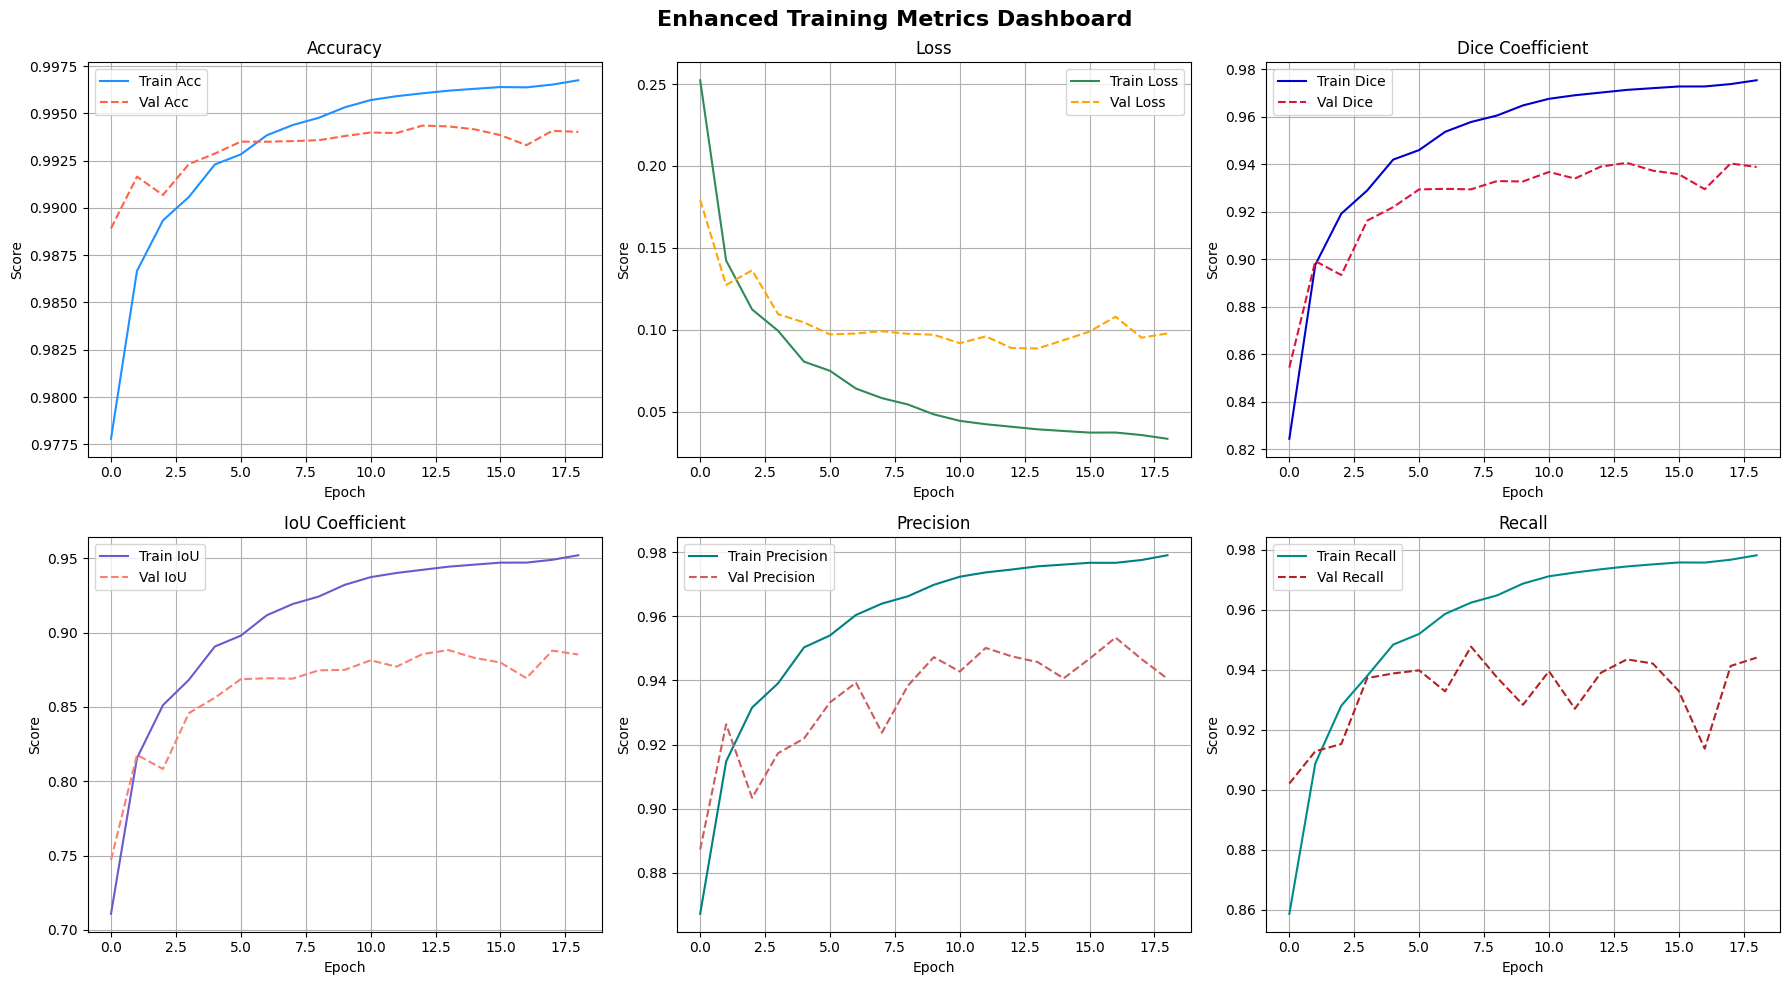


📊 Training Insights Summary
- Best Train Acc: 0.9967
- Best Val Acc  : 0.9943
- Min Train Loss: 0.0336
- Min Val Loss  : 0.0887

Overfitting Indicators:
- Max Accuracy Gap: 0.0111
- Max Loss Gap    : 0.0730
✅ Model Training Looks Stable


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_metrics(history, save_path=None):
    """
    Enhanced visualization for segmentation training history
    """
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Enhanced Training Metrics Dashboard', fontsize=16, fontweight='bold')

    # 1. Accuracy
    axs[0, 0].plot(history.history['accuracy'], label='Train Acc', color='dodgerblue')
    axs[0, 0].plot(history.history['val_accuracy'], label='Val Acc', color='tomato', linestyle='--')
    axs[0, 0].set_title('Accuracy')
    axs[0, 0].legend(); axs[0, 0].grid(True)

    # 2. Loss
    axs[0, 1].plot(history.history['loss'], label='Train Loss', color='seagreen')
    axs[0, 1].plot(history.history['val_loss'], label='Val Loss', color='orange', linestyle='--')
    axs[0, 1].set_title('Loss')
    axs[0, 1].legend(); axs[0, 1].grid(True)

    # 3. Dice Coefficient
    axs[0, 2].plot(history.history['dice_coefficient'], label='Train Dice', color='mediumblue')
    axs[0, 2].plot(history.history['val_dice_coefficient'], label='Val Dice', color='crimson', linestyle='--')
    axs[0, 2].set_title('Dice Coefficient')
    axs[0, 2].legend(); axs[0, 2].grid(True)

    # 4. IoU
    axs[1, 0].plot(history.history['iou_coefficient'], label='Train IoU', color='slateblue')
    axs[1, 0].plot(history.history['val_iou_coefficient'], label='Val IoU', color='salmon', linestyle='--')
    axs[1, 0].set_title('IoU Coefficient')
    axs[1, 0].legend(); axs[1, 0].grid(True)

    # 5. Precision
    axs[1, 1].plot(history.history['precision_segmentation'], label='Train Precision', color='teal')
    axs[1, 1].plot(history.history['val_precision_segmentation'], label='Val Precision', color='indianred', linestyle='--')
    axs[1, 1].set_title('Precision')
    axs[1, 1].legend(); axs[1, 1].grid(True)

    # 6. Recall
    axs[1, 2].plot(history.history['recall_segmentation'], label='Train Recall', color='darkcyan')
    axs[1, 2].plot(history.history['val_recall_segmentation'], label='Val Recall', color='firebrick', linestyle='--')
    axs[1, 2].set_title('Recall')
    axs[1, 2].legend(); axs[1, 2].grid(True)

    for ax in axs.flat:
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Score')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

def additional_training_insights(history):
    print("\n\U0001f4ca Training Insights Summary")
    print("- Best Train Acc: {:.4f}".format(max(history.history['accuracy'])))
    print("- Best Val Acc  : {:.4f}".format(max(history.history['val_accuracy'])))
    print("- Min Train Loss: {:.4f}".format(min(history.history['loss'])))
    print("- Min Val Loss  : {:.4f}".format(min(history.history['val_loss'])))

    acc_gap = np.max(np.abs(np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])))
    loss_gap = np.max(np.abs(np.array(history.history['loss']) - np.array(history.history['val_loss'])))

    print("\nOverfitting Indicators:")
    print("- Max Accuracy Gap: {:.4f}".format(acc_gap))
    print("- Max Loss Gap    : {:.4f}".format(loss_gap))
    if acc_gap > 0.1 or loss_gap > 0.5:
        print("\u26a0\ufe0f Potential Overfitting Detected")
    else:
        print("\u2705 Model Training Looks Stable")

# Usage:
plot_training_metrics(history, save_path='training_metrics.png')
additional_training_insights(history)


In [ ]:
# Baca COCO annotations
import json

annotation_file = "/content/Nail_Segmentation-4/train/_annotations.coco.json"  # Sesuaikan path

with open(annotation_file, "r") as f:
    data = json.load(f)

categories = data["categories"]
labels = [cat["name"] for cat in categories]

# Tulis labels.txt
with open("labels.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

print("Berhasil buat labels.txt:", labels)


Berhasil buat labels.txt: ['nails', 'nail']


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save TFLite Model
with open('/content/nailsegmentation_deeplabv3.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
model.save("check.keras")

In [ ]:
!pip uninstall tflite-support tensorflow-lite-support -y

In [ ]:
!pip install tflite-support-nightly --upgrade

In [ ]:
from tflite_support.metadata_writers import image_segmenter
from tflite_support.metadata_writers import writer_utils

In [ ]:
ImageSegmenterWriter = image_segmenter.MetadataWriter
_MODEL_PATH = "/content/nailsegmentation_deeplabv3.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "labels.txt"
_SAVE_TO_PATH = "/content/final_nail_with_metadata.tflite"
# Normalization parameters are required when reprocessing the image. It is
# optional if the image pixel values are in the range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/models/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageSegmenterWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageSegmenter",
  "description": "Semantic image segmentation predicts whether each pixel of an image is associated with a certain class.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be segmented.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
  

In [ ]:
# prompt: inference with the model 12 image of train dataset, and show the original, mask, and predict, dont use the existing class

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model' and 'valid_dataset' are defined from the previous code

# Select 3 images from the validation dataset
num_images = 100
for i in range(num_images):
    idx = i * 4 # Use a fixed index to get the first 12 images
    img, true_mask = train_dataset.load_image_and_mask(idx)

    # Predict mask using the trained model
    pred_mask = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_mask = (pred_mask > 0.5).astype(np.float32)

    # Display the results
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(true_mask.squeeze(), cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(pred_mask.squeeze(), cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')